In [15]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
sns.set_theme(style="whitegrid")


In [16]:
def process_crop(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    crop_name = file_path.split('/')[-1].split('_')[0]  # Extract crop name from file name

    # One-hot encode DISTRICT_NAME
    data = pd.get_dummies(data, columns=['DISTRICT_NAME'], prefix='DISTRICT', drop_first=True)

    # Removing outliers using IQR method
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

    # Prepare features (X) and target (y)
    X = data.drop(columns=['YEAR', 'CROP_TYPE', 'YIELD'])
    y = data['YIELD']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features for SVR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    svr_model = SVR(kernel='linear', C=10, epsilon=0.5)

    lr_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    svr_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred_lr = lr_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svr = svr_model.predict(X_test_scaled)

    # Evaluate models
    results = {
        "Crop": crop_name,
        "Model": ["Linear Regression", "Random Forest", "SVR"],
        "MAE": [
            mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_rf),
            mean_absolute_error(y_test, y_pred_svr),
        ],
        "RMSE": [
            np.sqrt(mean_squared_error(y_test, y_pred_lr)),
            np.sqrt(mean_squared_error(y_test, y_pred_rf)),
            np.sqrt(mean_squared_error(y_test, y_pred_svr)),
        ],
        "R²": [
            r2_score(y_test, y_pred_lr),
            r2_score(y_test, y_pred_rf),
            r2_score(y_test, y_pred_svr),
        ],
    }

    # Feature importance for Random Forest
    feature_importances = rf_model.feature_importances_
    importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}
    ).sort_values(by="Importance", ascending=False).head(10)

    return results, y_test, y_pred_lr, y_pred_rf, y_pred_svr, importance_df

Top 10 Features for BARLEY - Random Forest


,Feature,Importance
3,WINTER_HUMIDITY,0.270710
7,WINTER_RAINFALL,0.100553
5,SPRING_RAINFALL,0.075467
0,AUTUMN_HUMIDITY,0.066460
9,SPRING_TEMPERATURE,0.064789
10,SUMMER_TEMPERATURE,0.058204
12,AUTUMN_WIND_SPEED,0.043600
2,SUMMER_HUMIDITY,0.037776
1,SPRING_HUMIDITY,0.034822
8,AUTUMN_TEMPERATURE,0.034751


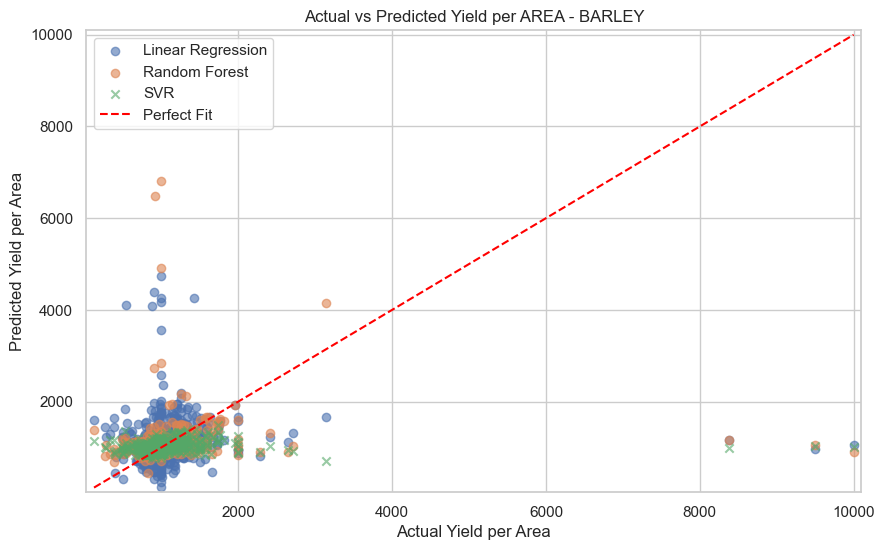

Top 10 Features for MAIZE - Random Forest


,Feature,Importance
1,SPRING_HUMIDITY,0.208110
7,WINTER_RAINFALL,0.125101
6,SUMMER_RAINFALL,0.068517
5,SPRING_RAINFALL,0.063621
61,DISTRICT_NAWALPARASI,0.058471
3,WINTER_HUMIDITY,0.055560
4,AUTUMN_RAINFALL,0.041236
24,DISTRICT_BHAKTAPUR,0.037315
0,AUTUMN_HUMIDITY,0.035757
14,SUMMER_WIND_SPEED,0.034379


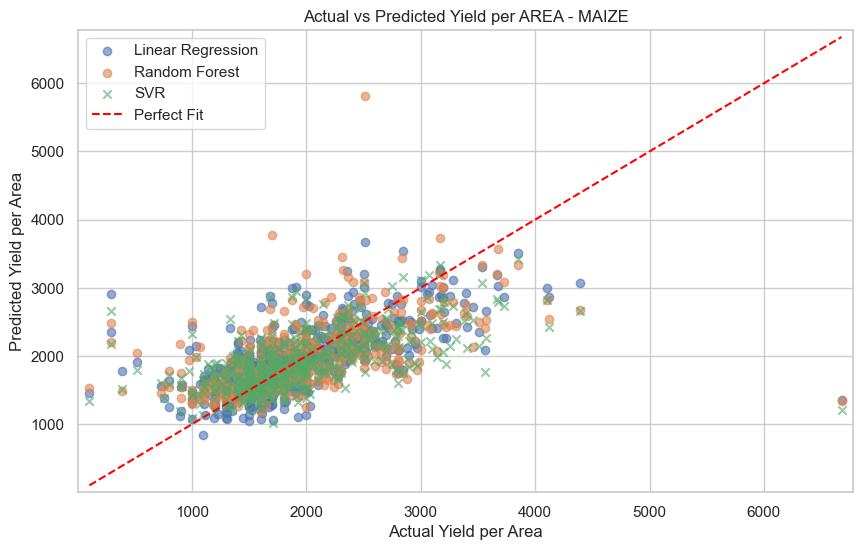

Top 10 Features for MILLET - Random Forest


,Feature,Importance
8,AUTUMN_TEMPERATURE,0.229068
11,WINTER_TEMPERATURE,0.102442
4,AUTUMN_RAINFALL,0.070536
15,WINTER_WIND_SPEED,0.052811
6,SUMMER_RAINFALL,0.052737
3,WINTER_HUMIDITY,0.046637
14,SUMMER_WIND_SPEED,0.045477
7,WINTER_RAINFALL,0.038356
2,SUMMER_HUMIDITY,0.035385
5,SPRING_RAINFALL,0.033501


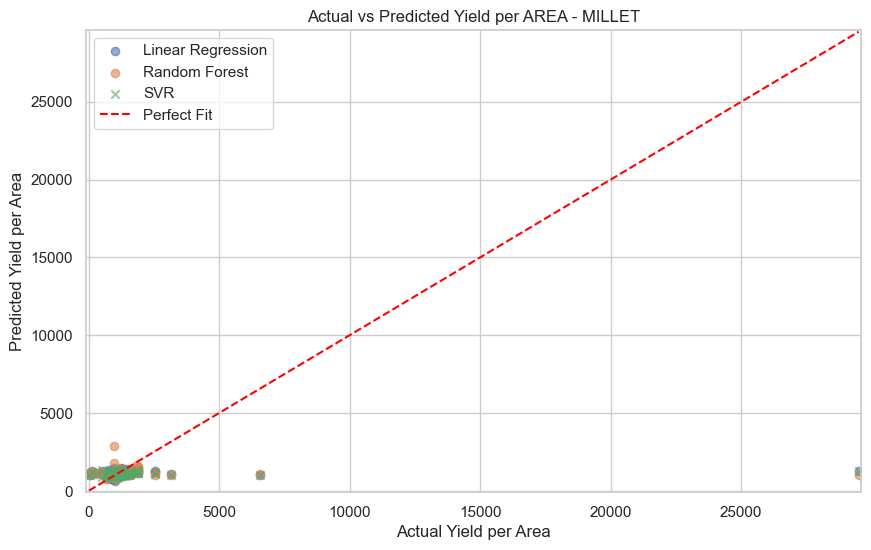

Top 10 Features for PADDY - Random Forest


,Feature,Importance
24,DISTRICT_BHAKTAPUR,0.151600
1,SPRING_HUMIDITY,0.102750
49,DISTRICT_KATHMANDU,0.090845
12,AUTUMN_WIND_SPEED,0.066076
6,SUMMER_RAINFALL,0.060768
14,SUMMER_WIND_SPEED,0.060260
52,DISTRICT_LALITPUR,0.054973
0,AUTUMN_HUMIDITY,0.054409
2,SUMMER_HUMIDITY,0.050292
5,SPRING_RAINFALL,0.039783


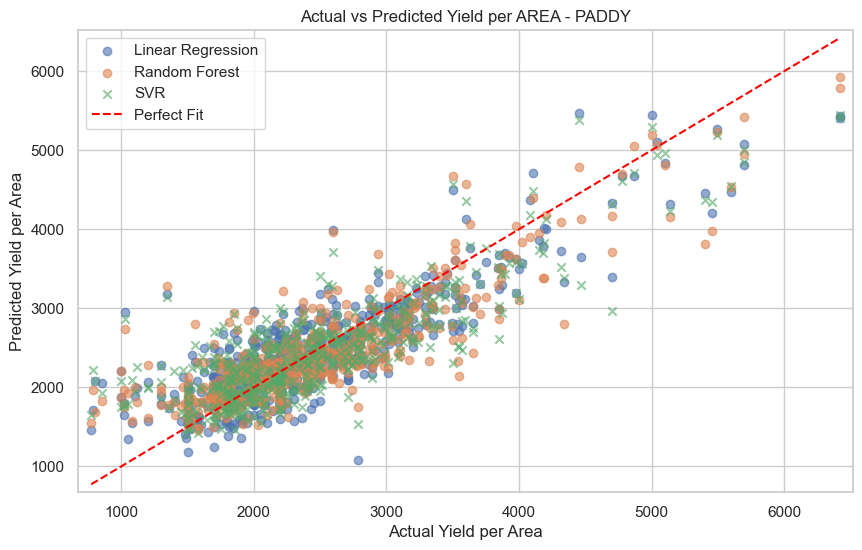

Top 10 Features for WHEAT - Random Forest


,Feature,Importance
1,SPRING_HUMIDITY,0.260287
5,SPRING_RAINFALL,0.104915
0,AUTUMN_HUMIDITY,0.074807
6,SUMMER_RAINFALL,0.068247
3,WINTER_HUMIDITY,0.052830
14,SUMMER_WIND_SPEED,0.051240
24,DISTRICT_BHAKTAPUR,0.046617
4,AUTUMN_RAINFALL,0.044794
7,WINTER_RAINFALL,0.043935
2,SUMMER_HUMIDITY,0.035731


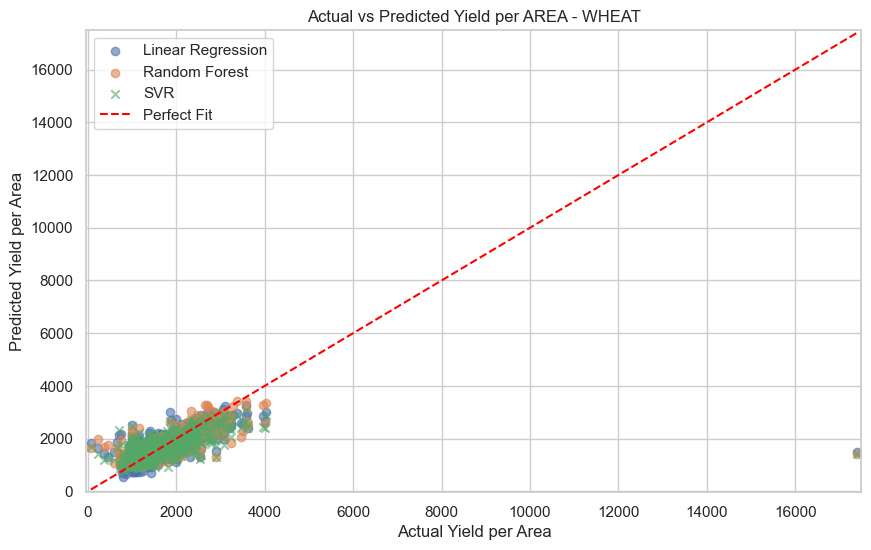

In [17]:
# List of file paths
file_paths = [
    "FinalDatasets/BARLEY_data_merged.csv",
    "FinalDatasets/MAIZE_data_merged.csv",
    "FinalDatasets/MILLET_data_merged.csv",
    "FinalDatasets/PADDY_data_merged.csv",
    "FinalDatasets/WHEAT_data_merged.csv",
]

# Initialize summary DataFrame
summary_df = pd.DataFrame()

# Loop through each crop
for file_path in file_paths:
    results, y_test, y_pred_lr, y_pred_rf, y_pred_svr, importance_df = process_crop(file_path)

    # Append results to summary DataFrame
    summary_df = pd.concat([summary_df, pd.DataFrame(results)], ignore_index=True)

    # Display crop-specific feature importance
    crop_name = results["Crop"]
    print(f"Top 10 Features for {crop_name} - Random Forest")
    display(importance_df)  # Jupyter-friendly display

    # Call the visualization function
    visualize_influencers(importance_df, crop_name)

    # Scatter plot: Actual vs Predicted
    plt.figure(figsize=(10, 6))

    # Plot each model's prediction
    plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha=0.6)
    plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.6)
    plt.scatter(y_test, y_pred_svr, label="SVR", alpha=0.6, marker="x")

    # Plot the "Perfect Fit" line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--", color="red", label="Perfect Fit")

    # Set the axis limits based on the range of actual and predicted values
    all_values = np.concatenate([y_test, y_pred_lr, y_pred_rf, y_pred_svr])
    plt.xlim(all_values.min() - 100, all_values.max() + 100)  # Adjust padding as needed
    plt.ylim(all_values.min() - 100, all_values.max() + 100)

    # Title and labels
    plt.title(f"Actual vs Predicted Yield per AREA - {crop_name}")
    plt.xlabel("Actual Yield per Area")
    plt.ylabel("Predicted Yield per Area")

    # Add a legend to differentiate between the models
    plt.legend()

    # Show the plot
    plt.show()


Model Performance Summary:


,Crop,Model,MAE,RMSE,R²
0,BARLEY,Linear Regression,397.16,834.28,-0.49
1,BARLEY,Random Forest,269.46,783.98,-0.32
2,BARLEY,SVR,231.12,683.02,-0.00
3,MAIZE,Linear Regression,325.26,488.62,0.41
4,MAIZE,Random Forest,335.16,522.51,0.33
5,MAIZE,SVR,342.73,511.21,0.36
6,MILLET,Linear Regression,198.00,1256.39,0.01
7,MILLET,Random Forest,188.70,1265.85,-0.00
8,MILLET,SVR,188.52,1255.60,0.01
9,PADDY,Linear Regression,322.77,424.41,0.74


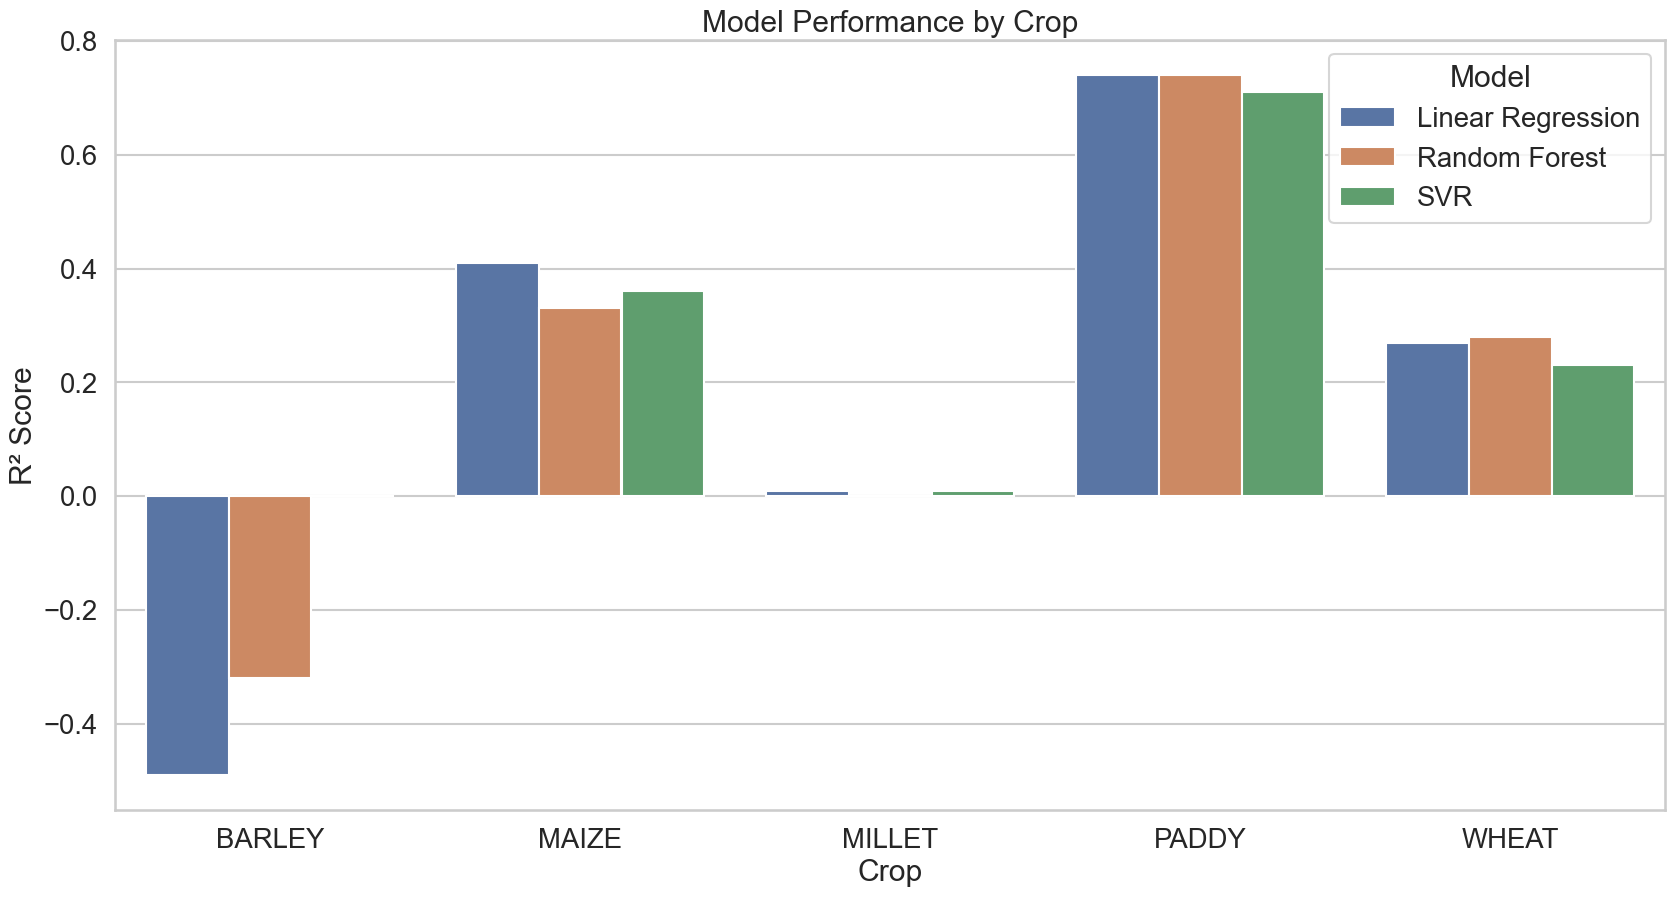

In [18]:
# Summary of all results
summary_df = summary_df.round(2)
print("Model Performance Summary:")
display(summary_df)  # Jupyter-friendly display of the summary
# Display the summary DataFrame as a clear table
plt.figure(figsize=(20, 10))
# Increase font size
sns.set_context("talk", font_scale=1.2)
# Save the plot with transparent background

sns.barplot(x="Crop", y="R²", hue="Model", data=summary_df)
plt.title("Model Performance by Crop")
plt.ylabel("R² Score")
plt.xlabel("Crop")
plt.legend(title="Model")
plt.show()
